# Read in the data

In [18]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt



data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [12]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [13]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## 1.Plotting survey correlations

In [14]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [16]:
#Investigate safety scores

In [22]:
%matplotlib inline

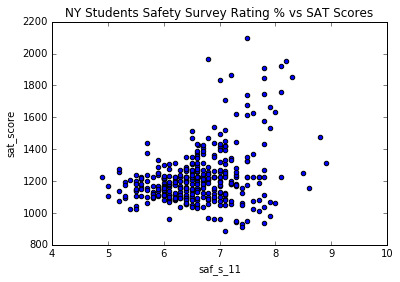

In [161]:
combined.plot('saf_s_11', 'sat_score', kind='scatter')
plt.title("NY Students Safety Survey Rating % vs SAT Scores")

**Conclusions**
- There's certain (though not very strong) correlation between SAT scores and safety. 
- There are a few schools where the students' safety rating are higher and the corresponding SAT scores. 
- On the other hand, there are also schools' students' safety rating are low, and their SAT scores are low as well. 
- Overall, no school's avg safety scores are lower than 6.5 had SAT scores higher than 1400.

## 2. Plot Safety Scores

In [30]:
combined.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'priority05', 'priority06', 'priority07', 'priority08', 'priority09',
       'priority10', 'Location 1', 'lat', 'lon', 'school_dist'],
      dtype='object', length=160)

In [37]:
from mpl_toolkits.basemap import Basemap
import numpy as np

In [48]:
#Compute the average safety score for each district.
#Make a map that shows safety scores by district.

districts=combined.groupby('school_dist').agg(np.mean)
districts.reset_index(inplace=True)

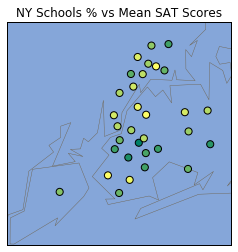

In [160]:
m=Basemap(
    projection='merc',
    llcrnrlat=40.496044,
    urcrnrlat=40.915256,
    llcrnrlon=-74.255735,
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
               
longitudes=districts['lon'].tolist()
latitudes=districts['lat'].tolist()

m.scatter(longitudes, latitudes, s=50,zorder=2, latlon=True, c=districts['saf_s_11'], cmap='summer') 
plt.title("NY Schools % vs Mean SAT Scores")

It looks like <span style="color:blue">**Upper Manhattan**</span> and some parts of <span style="color:blue">**Queens and Bronx**</span> have __higher safety scores__, while <span style="color:blue">**Brooklyn**</span> has __lower safety scores__.

## 3. Racial differences in SAT scores

In [112]:
#Investigate racial differences in SAT scores.
#Make a bar plot of the correlations between the race % and sat_score.

In [74]:
races = ["white_per", "asian_per", "black_per", "hispanic_per"]

In [78]:
combined.corr()['sat_score'].head()

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
Name: sat_score, dtype: float64

In [79]:
#filter the correlations to show sat_scores and races only
combined.corr()['sat_score'][races]

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64

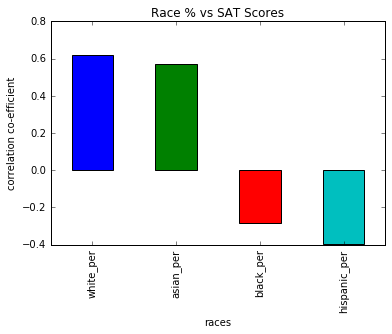

In [159]:
cor['sat_score'][races].plot(kind='bar')
plt.xlabel('races')
plt.ylabel('correlation co-efficient')
plt.title("Race % vs SAT Scores")

**Conclusions**
- Both white and asian races had a high, positive correlations to the SAT_scores
- While both Black and Hispanic races had a low and positibe correlations to the SAT scores
- This maybe due to lack of school fundings to NY districts where most black and hispanic race students reside.

In [98]:
#Explore schools with low SAT scores and high values for hispanic_per

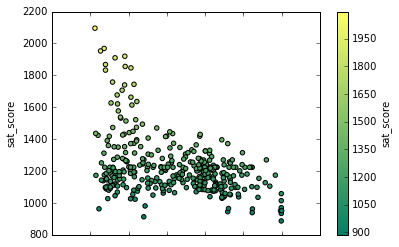

In [105]:
combined.plot(x='hispanic_per',y='sat_score',kind='scatter', c='sat_score', cmap='summer')

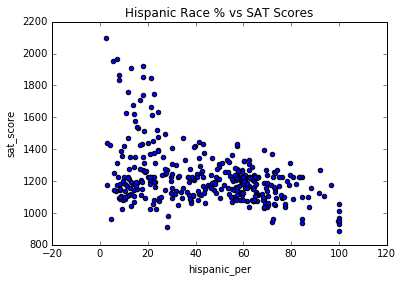

In [158]:
combined.plot(x='hispanic_per',y='sat_score',kind='scatter')
plt.title("Hispanic Race % vs SAT Scores")

In [108]:
#school districts where the hispanic_per is over 95%
combined[combined['hispanic_per']>95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [110]:
#school districts where the hispanic_per is less than 10%
combined[(combined['hispanic_per']<10)&(combined['sat_score']>1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Many of these schools are focusing on science and technologies,which receive extra fundings from the the department of education.
Students also need to pass entrance exam to be admitted. However, there's not much info regarding the hispanic ratio, however, students' SAT scores are higher in general.

## 4. Gender differences in SAT scores

In [113]:
#Investigate gender differences in SAT scores.
#Make a bar plot of the correlations between the columns above and sat_score.

In [124]:
#combined.loc['sat_score',['male_per', 'female_per']]
df=combined.corr()
df=df.loc['sat_score',['male_per', 'female_per']]
df

male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64

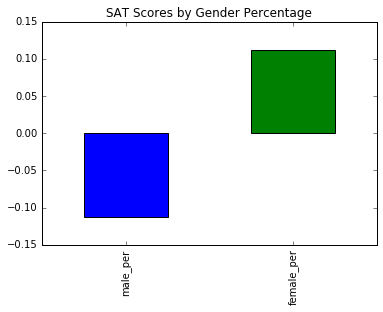

In [157]:
df.plot(kind='bar')
plt.title("SAT Scores by Gender Percentage")

It looks like the female_percentage has a positive correlation with the SAT scores. While the male_percentage has a negative correlation. However, neither of them have a strong correlation (>0.25)

In [129]:
#Investigate schools with high SAT scores and a high female_per.
#Make a scatter plot of female_per vs. sat_score.

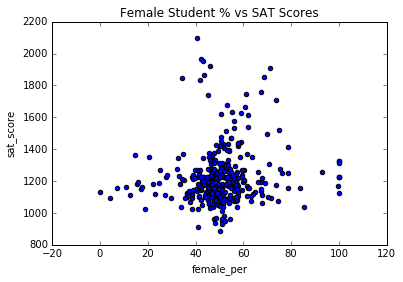

In [156]:
combined.plot(x='female_per', y='sat_score', kind='scatter')
plt.title("Female Student % vs SAT Scores")

- The scatter plot shown above doesn't conclude a strong correlation between the female percentage and the sat scores in this case. 
- However, there's a  cluster of schools in the middle with female percentage between 50-80% have higher sat scores (>1500)

In [132]:
#Research any schools with a female_per greater than 60% and an average SAT score greater than 1700

In [135]:
combined[(combined['female_per']>60)&(combined['sat_score']>1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools appear to be academically rigorous esp. in the liberal arts, and some of the schools require a strict test to select students.

## AP Scores vs SAT Scores

In [136]:
#Calculate the percentage of students in each school that took an AP exam.
#Divide the AP Test Takers column by the total_enrollment column
#Assign the result to the ap_per column.

In [143]:
ap_per=combined['AP Test Takers ']/combined['total_enrollment']
combined['ap_per']=ap_per

In [144]:
#Investigate the relationship between AP scores and SAT scores.
#Make a scatter plot of ap_per vs. sat_score.

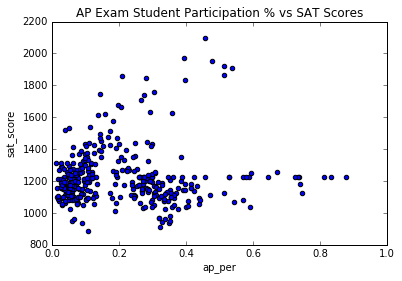

In [155]:
combined.plot(x='ap_per', y='sat_score', kind='scatter',xlim=(0,1),title="AP Exam Student Participation % vs SAT Scores")
#plt.title("AP Exam Student Participation % vs SAT Scores")

The scatterplot shown above display a certain level of correlation between the percentage of students who take the AP exams and their SAT Scores. But it is not a very strong correlation in this case.